# 🎧 K-Means Clustering — **Song Mood / Production Typology (Global)**

**Versi v3 — Optimized Mode:**  
- **Evaluasi K pakai Elbow Method + Silhouette** (lebih akurat).  
- **Init K-Means = `k-means++`** dengan multiple runs untuk hasil optimal.  
- **Silhouette dengan sampling** untuk efisiensi pada dataset besar.
- Tetap ada **ekspor cleaned dataset** untuk benchmark di **Orange Data Mining**.


## 0) Setup & Konfigurasi

In [2]:
from pathlib import Path

DATA_DIR = Path("data")  # ganti sesuai lokasi ekstraksi CSV Kaggle
MAX_ROWS = 200_000               # set None bila ingin memuat semua
K_MIN, K_MAX = 2, 15             # range K untuk scanning (diperluas untuk melihat elbow lebih jelas)

print("DATA_DIR:", DATA_DIR.resolve())
print("MAX_ROWS:", MAX_ROWS)
print("K range:", (K_MIN, K_MAX))


DATA_DIR: /content/data
MAX_ROWS: 200000
K range: (2, 15)


## 1) Import Library

In [3]:
import warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)


In [ ]:
# Install library untuk elbow detection (jalankan jika belum terinstall)
# !pip install kneed

## 2) Load Dataset (Auto-Detect CSV)

In [4]:
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter

print(f"Mengunduh dan memuat dataset dari Kaggle (maksimal {MAX_ROWS} baris)...")

# Definisikan handle dataset dan path file secara TERPISAH
dataset_handle = "rodolfofigueroa/spotify-12m-songs"
file_path = "tracks_features.csv"

# Muat dataset menggunakan kagglehub dengan dua argumen terpisah
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset_handle,
    file_path,  # Ini adalah argumen 'path' yang diminta oleh error
    # Gunakan pandas_kwargs untuk meneruskan argumen ke pd.read_csv
    pandas_kwargs={'nrows': MAX_ROWS}
)

print("\nDataset berhasil dimuat!")
print("Jumlah baris dan kolom:", df.shape)
print("Lima data pertama:")
df.head()

Mengunduh dan memuat dataset dari Kaggle (maksimal 200000 baris)...
Using Colab cache for faster access to the 'spotify-12m-songs' dataset.

Dataset berhasil dimuat!
Jumlah baris dan kolom: (200000, 24)
Lima data pertama:


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


## 3) Baca Data & Seleksi Kolom

In [6]:
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter

# Definisikan konstanta dan variabel
MAX_ROWS = 5000  # Anda bisa sesuaikan jumlah baris maksimal
dataset_handle = "rodolfofigueroa/spotify-12m-songs"
file_path = "tracks_features.csv"

# ---------------------------------------------------------------------------
# LANGKAH 1: Unduh dan muat dataset dari Kaggle
# ---------------------------------------------------------------------------
print(f"Mengunduh dan memuat dataset dari Kaggle (maksimal {MAX_ROWS} baris)...")
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset_handle,
    file_path,
    pandas_kwargs={'nrows': MAX_ROWS}
)
print("\nDataset awal berhasil dimuat!")
print("Jumlah baris dan kolom awal:", df.shape)


# ---------------------------------------------------------------------------
# LANGKAH 2: Proses DataFrame yang sudah dimuat (TANPA membaca ulang file)
# ---------------------------------------------------------------------------
print("\nMemproses DataFrame...")

# Definisikan kandidat kolom fitur dan metadata
FEATURE_COLS_CANDIDATES = [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature'
]
META_COLS_CANDIDATES = [
    'name','track_name','artists','artist_name','popularity','year','release_date','id','track_id'
]

# Dapatkan kolom yang tersedia langsung dari DataFrame yang sudah ada
available_cols = set(df.columns)

# Buat pemetaan untuk mengganti nama kolom agar konsisten
rename_map = {}
if 'name' in available_cols and 'track_name' not in available_cols:
    rename_map['name'] = 'track_name'
if 'artist_name' in available_cols and 'artists' not in available_cols:
    rename_map['artist_name'] = 'artists'
if 'id' in available_cols and 'track_id' not in available_cols:
    rename_map['id'] = 'track_id'

# Tentukan kolom mana yang akan digunakan dari yang tersedia
usecols = [c for c in FEATURE_COLS_CANDIDATES + META_COLS_CANDIDATES if c in available_cols]

# Tentukan tipe data untuk optimasi memori
dtype_map = {
    'danceability':'float32','energy':'float32','acousticness':'float32',
    'instrumentalness':'float32','liveness':'float32','speechiness':'float32',
    'valence':'float32','tempo':'float32','loudness':'float32',
    'duration_ms':'int32','key':'int8','mode':'int8','time_signature':'int8',
    'popularity':'int16','year':'int16'
}

# 1. Filter DataFrame agar hanya menggunakan kolom yang dibutuhkan
df = df[usecols]

# 2. Ganti nama kolom sesuai peta
df.rename(columns=rename_map, inplace=True)

# 3. Buat dictionary dtype yang hanya berisi kolom yang ada di DataFrame final
#    dan ubah tipe datanya untuk optimasi memori.
final_dtype_map = {k: v for k, v in dtype_map.items() if k in df.columns}
df = df.astype(final_dtype_map)


# (Opsional) Jika Anda memuat lebih dari MAX_ROWS dan ingin mengambil sampel acak
if MAX_ROWS is not None and len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)

print("\nDataFrame berhasil diproses!")
print("Shape final:", df.shape)
print("Tiga data pertama setelah diproses:")
display(df.head(3))

print("\nInfo memori setelah optimasi tipe data:")
df.info(memory_usage='deep')

Mengunduh dan memuat dataset dari Kaggle (maksimal 5000 baris)...
Using Colab cache for faster access to the 'spotify-12m-songs' dataset.

Dataset awal berhasil dimuat!
Jumlah baris dan kolom awal: (5000, 24)

Memproses DataFrame...

DataFrame berhasil diproses!
Shape final: (5000, 18)
Tiga data pertama setelah diproses:


,danceability,energy,acousticness,instrumentalness,liveness,speechiness,valence,tempo,loudness,duration_ms,key,mode,time_signature,track_name,artists,year,release_date,track_id
0,0.470,0.978,0.0261,0.000011,0.356,0.0727,0.503,117.905998,-5.399,210133,7,1,4,Testify,['Rage Against The Machine'],1999,1999-11-02,7lmeHLHBe4nmXzuXc0HDjk
1,0.599,0.957,0.0129,0.000071,0.155,0.1880,0.489,103.680000,-5.764,206200,11,1,4,Guerrilla Radio,['Rage Against The Machine'],1999,1999-11-02,1wsRitfRRtWyEapl0q22o8
2,0.315,0.970,0.0234,0.000002,0.122,0.4830,0.370,149.748993,-5.424,298893,7,1,4,Calm Like a Bomb,['Rage Against The Machine'],1999,1999-11-02,1hR0fIFK2qRG3f3RF70pb7



Info memori setelah optimasi tipe data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5000 non-null   float32
 1   energy            5000 non-null   float32
 2   acousticness      5000 non-null   float32
 3   instrumentalness  5000 non-null   float32
 4   liveness          5000 non-null   float32
 5   speechiness       5000 non-null   float32
 6   valence           5000 non-null   float32
 7   tempo             5000 non-null   float32
 8   loudness          5000 non-null   float32
 9   duration_ms       5000 non-null   int32  
 10  key               5000 non-null   int8   
 11  mode              5000 non-null   int8   
 12  time_signature    5000 non-null   int8   
 13  track_name        5000 non-null   object 
 14  artists           5000 non-null   object 
 15  year              5000 non-null   int16  
 16  r

## 4) Pembersihan Data

In [7]:
has_track_id = 'track_id' in df.columns
has_track_name = 'track_name' in df.columns
has_artists = 'artists' in df.columns

if has_track_id:
    df = df.drop_duplicates(subset=['track_id'])
elif has_track_name and has_artists:
    df = df.drop_duplicates(subset=['track_name','artists'])

FEATS = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature'
] if c in df.columns]

df = df.dropna(subset=FEATS)

if 'tempo' in df.columns:
    df['tempo'] = df['tempo'].clip(30, 250)
if 'loudness' in df.columns:
    df['loudness'] = df['loudness'].clip(-60, 5)
if 'duration_ms' in df.columns:
    df['duration_ms'] = df['duration_ms'].clip(10_000, 900_000)

print("Setelah cleaning:", df.shape)
df[FEATS].describe().T


Setelah cleaning: (5000, 18)


,count,mean,std,min,25%,50%,75%,max
danceability,5000.0,0.499810,0.183373,0.000000,0.377000,0.511500,0.633000,0.957000
energy,5000.0,0.554207,0.282064,0.000020,0.325000,0.580000,0.806000,1.000000
acousticness,5000.0,0.365996,0.358523,0.000000,0.023375,0.233000,0.718000,0.995000
instrumentalness,5000.0,0.229888,0.354296,0.000000,0.000002,0.001315,0.498250,0.990000
liveness,5000.0,0.210848,0.192886,0.000000,0.098375,0.128000,0.261250,1.000000
speechiness,5000.0,0.085820,0.125064,0.000000,0.033800,0.043400,0.070800,0.956000
valence,5000.0,0.456054,0.268258,0.000000,0.226000,0.450000,0.673000,0.984000
tempo,5000.0,119.377937,31.349161,30.000000,95.029499,117.798500,139.772251,212.154999
loudness,5000.0,-11.155878,6.268978,-45.756001,-14.041500,-9.645000,-6.680000,3.802000
duration_ms,5000.0,244917.290600,115393.861179,10000.000000,181060.250000,228500.000000,281306.500000,900000.000000


## 5) Feature Engineering & Scaling

In [8]:
work = df.copy()

if 'duration_ms' in work.columns:
    work['duration_s'] = work['duration_ms'] / 1000.0
    work['log_duration_s'] = np.log1p(work['duration_s'])

if 'key' in work.columns:
    import numpy as np
    two_pi = 2*np.pi
    work['key_sin'] = np.sin(two_pi * (work['key'] % 12) / 12.0)
    work['key_cos'] = np.cos(two_pi * (work['key'] % 12) / 12.0)

num_feats = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','log_duration_s','key_sin','key_cos'
] if c in work.columns]
bin_feats = [c for c in ['mode'] if c in work.columns]
cat_small = [c for c in ['time_signature'] if c in work.columns]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

transformers = []
if num_feats:
    transformers.append(("num", StandardScaler(), num_feats))
if bin_feats:
    transformers.append(("bin", "passthrough", bin_feats))
if cat_small:
    transformers.append(("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_small))

preprocess = ColumnTransformer(transformers=transformers, remainder='drop')
X = preprocess.fit_transform(work)
print("Shape X:", X.shape)


Shape X: (5000, 18)


## 5.1) Analisis & Cleaning Korelasi Antar-Fitur

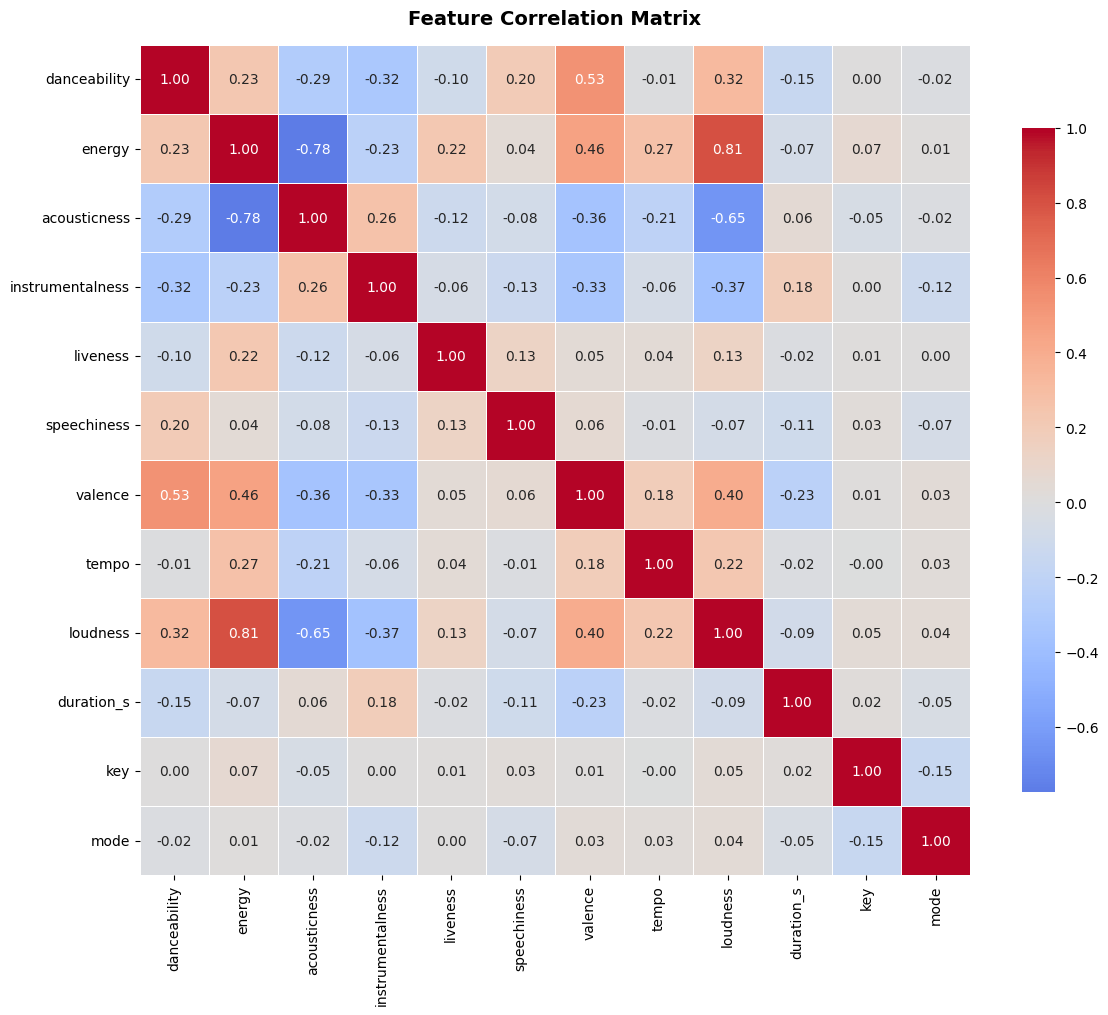


🔍 HIGH CORRELATION PAIRS (|r| > 0.9):
   ✓ No highly redundant features found (all |r| ≤ 0.9)

📊 MODERATE-HIGH CORRELATION PAIRS (0.7 < |r| ≤ 0.9):
   energy ↔ loudness: r = 0.809
   energy ↔ acousticness: r = -0.775


In [9]:
import seaborn as sns

# Hitung correlation matrix untuk fitur numerik
numeric_features = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_s','key','mode'
] if c in work.columns]

corr_matrix = work[numeric_features].corr()

# Visualisasi heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Identifikasi fitur dengan korelasi tinggi (> 0.9)
print("\n" + "="*60)
print("🔍 HIGH CORRELATION PAIRS (|r| > 0.9):")
print("="*60)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_pairs.append(pair)
            print(f"   {pair[0]} ↔ {pair[1]}: r = {pair[2]:.3f}")

if not high_corr_pairs:
    print("   ✓ No highly redundant features found (all |r| ≤ 0.9)")
else:
    print(f"\n⚠️  Found {len(high_corr_pairs)} redundant pair(s) - consider removing one from each pair")

# Identifikasi korelasi moderat-tinggi (0.7 - 0.9) untuk awareness
print("\n" + "="*60)
print("📊 MODERATE-HIGH CORRELATION PAIRS (0.7 < |r| ≤ 0.9):")
print("="*60)

mod_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if 0.7 < abs(corr_matrix.iloc[i, j]) <= 0.9:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            mod_corr_pairs.append(pair)

if mod_corr_pairs:
    # Sort by absolute correlation
    mod_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for pair in mod_corr_pairs[:10]:  # Show top 10
        print(f"   {pair[0]} ↔ {pair[1]}: r = {pair[2]:.3f}")
else:
    print("   No moderate-high correlations found")

print("="*60)

## 5.2) Feature Selection & Engineering (Optimized)

In [10]:
# Strategi pemilihan fitur berdasarkan analisis korelasi & domain knowledge
print("="*60)
print("📝 FEATURE SELECTION STRATEGY")
print("="*60)

# Fitur yang PASTI dipakai (core mood/production features)
core_features = [
    'danceability',      # Groove/rhythm
    'energy',            # Intensity
    'acousticness',      # Production style
    'instrumentalness',  # Vocal presence
    'valence',           # Emotional tone
    'speechiness',       # Speech content
]

# Fitur tambahan (production quality)
production_features = [
    'loudness',          # Mix quality
    'tempo',             # BPM
    'log_duration_s',    # Song length (transformed)
]

# Fitur kategorikal yang sudah di-encode
categorical_encoded = [
    'key_sin', 'key_cos',  # Tonal center (circular encoding)
    'mode',                # Major/minor
]

# Fitur yang mungkin redundan/noisy
# - liveness: sering noise, kecuali fokus ke live music
# - time_signature: kebanyakan 4/4, variance rendah
potentially_redundant = ['liveness', 'time_signature']

# Final feature set
selected_features = core_features + production_features + categorical_encoded

print(f"\n✓ Core features ({len(core_features)}): {core_features}")
print(f"✓ Production features ({len(production_features)}): {production_features}")
print(f"✓ Categorical encoded ({len(categorical_encoded)}): {categorical_encoded}")
print(f"⚠️  Potentially redundant/noisy: {potentially_redundant}")
print(f"\n📊 Total selected features: {len(selected_features)}")
print("="*60)

# Verify semua fitur ada di dataframe
selected_features_available = [f for f in selected_features if f in work.columns]
print(f"\n✓ Available features: {len(selected_features_available)}/{len(selected_features)}")
if len(selected_features_available) < len(selected_features):
    missing = set(selected_features) - set(selected_features_available)
    print(f"⚠️  Missing features: {missing}")

SELECTED_FEATURES = selected_features_available

📝 FEATURE SELECTION STRATEGY

✓ Core features (6): ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness']
✓ Production features (3): ['loudness', 'tempo', 'log_duration_s']
✓ Categorical encoded (3): ['key_sin', 'key_cos', 'mode']
⚠️  Potentially redundant/noisy: ['liveness', 'time_signature']

📊 Total selected features: 12

✓ Available features: 12/12


## 5.3) Dimensionality Reduction: PCA 20-30D

Original feature space: (5000, 12)
Features: ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness', 'loudness', 'tempo', 'log_duration_s', 'key_sin', 'key_cos', 'mode']


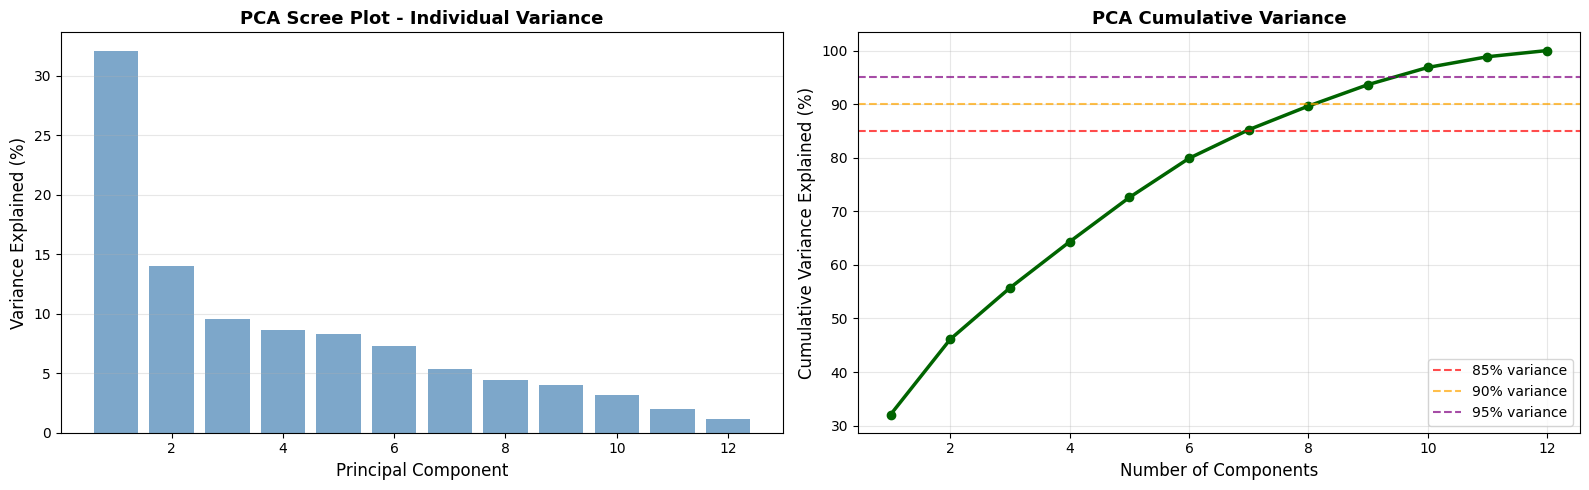


📊 PCA COMPONENT ANALYSIS:
Total available components: 12
Components for 85% variance: 7 (cumvar: 85.22%)
Components for 90% variance: 9 (cumvar: 93.64%)
Components for 95% variance: 10 (cumvar: 96.84%)

💡 Strategy: Using minimum target (12 components)
   ⚠️  Note: Only 12 components available (< 20)

🎯 SELECTED: 12 components (explains 100.00% variance)

✓ PCA transformation complete!
   Input shape: (5000, 12)
   Output shape: (5000, 12)
   Variance explained: 100.00%


In [11]:
# Re-build preprocessing dengan fitur terpilih saja
num_feats_selected = [c for c in SELECTED_FEATURES if c not in ['mode', 'key_sin', 'key_cos']]
bin_feats_selected = [c for c in ['mode'] if c in SELECTED_FEATURES]
cyclic_feats = [c for c in ['key_sin', 'key_cos'] if c in SELECTED_FEATURES]

transformers_v2 = []
if num_feats_selected:
    transformers_v2.append(("num", StandardScaler(), num_feats_selected))
if bin_feats_selected:
    transformers_v2.append(("bin", "passthrough", bin_feats_selected))
if cyclic_feats:
    transformers_v2.append(("cyclic", "passthrough", cyclic_feats))

preprocess_v2 = ColumnTransformer(transformers=transformers_v2, remainder='drop')
X_selected = preprocess_v2.fit_transform(work)

print(f"Original feature space: {X_selected.shape}")
print(f"Features: {SELECTED_FEATURES}")

# PCA untuk dimensionality reduction
# Target: 20-30D yang menjelaskan 85-95% variance
from sklearn.decomposition import PCA

# Scan untuk menemukan n_components optimal
pca_full = PCA(random_state=42)
pca_full.fit(X_selected)

cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Plot scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Individual variance
ax1.bar(range(1, len(pca_full.explained_variance_ratio_)+1),
        pca_full.explained_variance_ratio_*100, alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained (%)', fontsize=12)
ax1.set_title('PCA Scree Plot - Individual Variance', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative variance
ax2.plot(range(1, len(cumsum_var)+1), cumsum_var*100,
         marker='o', linewidth=2.5, markersize=6, color='darkgreen')
ax2.axhline(y=85, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='85% variance')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% variance')
ax2.axhline(y=95, color='purple', linestyle='--', linewidth=1.5, alpha=0.7, label='95% variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
ax2.set_title('PCA Cumulative Variance', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal n_components
max_components = len(cumsum_var)  # Maximum available components
n_for_85 = np.argmax(cumsum_var >= 0.85) + 1 if np.any(cumsum_var >= 0.85) else max_components
n_for_90 = np.argmax(cumsum_var >= 0.90) + 1 if np.any(cumsum_var >= 0.90) else max_components
n_for_95 = np.argmax(cumsum_var >= 0.95) + 1 if np.any(cumsum_var >= 0.95) else max_components

print("\n" + "="*60)
print("📊 PCA COMPONENT ANALYSIS:")
print("="*60)
print(f"Total available components: {max_components}")
print(f"Components for 85% variance: {n_for_85} (cumvar: {cumsum_var[n_for_85-1]*100:.2f}%)")
print(f"Components for 90% variance: {n_for_90} (cumvar: {cumsum_var[n_for_90-1]*100:.2f}%)")
print(f"Components for 95% variance: {n_for_95} (cumvar: {cumsum_var[n_for_95-1]*100:.2f}%)")

# Target: 20-30 components (or max available if less)
# Strategi: ambil yang paling mendekati target range sambil maximize variance
target_min = min(20, max_components)
target_max = min(30, max_components)

if target_min <= n_for_90 <= target_max:
    N_COMPONENTS = n_for_90
    print(f"\n💡 Strategy: Using 90% variance threshold")
elif target_min <= n_for_85 <= target_max:
    N_COMPONENTS = n_for_85
    print(f"\n💡 Strategy: Using 85% variance threshold")
elif n_for_85 < target_min:
    # Use all available components if we can't reach target range
    N_COMPONENTS = min(target_min, max_components)
    print(f"\n💡 Strategy: Using minimum target ({N_COMPONENTS} components)")
    if max_components < 20:
        print(f"   ⚠️  Note: Only {max_components} components available (< 20)")
else:  # n_for_85 > target_max
    # Use middle of target range
    N_COMPONENTS = min((target_min + target_max) // 2, max_components)
    print(f"\n💡 Strategy: Using middle of target range")

print(f"\n🎯 SELECTED: {N_COMPONENTS} components (explains {cumsum_var[N_COMPONENTS-1]*100:.2f}% variance)")
print("="*60)

# Apply PCA transformation
pca_reduced = PCA(n_components=N_COMPONENTS, random_state=42)
X_pca = pca_reduced.fit_transform(X_selected)

print(f"\n✓ PCA transformation complete!")
print(f"   Input shape: {X_selected.shape}")
print(f"   Output shape: {X_pca.shape}")
print(f"   Variance explained: {cumsum_var[N_COMPONENTS-1]*100:.2f}%")

## 5.4) Spherical K-Means (Cosine Distance via L2 Normalization)

In [12]:
from sklearn.preprocessing import normalize

# L2 normalization untuk spherical K-Means
# Ini membuat algoritma fokus ke "direction" bukan "magnitude"
# Efektif untuk high-dimensional data & text-like features
X_spherical = normalize(X_pca, norm='l2', axis=1)

print("="*60)
print("🌐 SPHERICAL K-MEANS PREPARATION")
print("="*60)
print(f"Data shape: {X_spherical.shape}")
print(f"L2 norm check (should be ~1.0): {np.linalg.norm(X_spherical[0]):.6f}")
print(f"\nSpherical K-Means benefits:")
print("  ✓ Focus on feature patterns (direction) rather than magnitude")
print("  ✓ Better for high-dimensional spaces")
print("  ✓ Equivalent to using cosine similarity")
print("  ✓ Often improves silhouette scores")
print("="*60)

🌐 SPHERICAL K-MEANS PREPARATION
Data shape: (5000, 12)
L2 norm check (should be ~1.0): 1.000000

Spherical K-Means benefits:
  ✓ Focus on feature patterns (direction) rather than magnitude
  ✓ Better for high-dimensional spaces
  ✓ Equivalent to using cosine similarity
  ✓ Often improves silhouette scores


## 6) Scan K dengan Elbow + Silhouette (PCA + Spherical Version)

In [13]:
import time

# K range adjustment - untuk spherical, bisa coba K lebih kecil karena lebih distinct
K_MIN_V2 = 3
K_MAX_V2 = 12

use_minibatch_v2 = (X_spherical.shape[0] > 300_000)
ks_v2 = list(range(K_MIN_V2, K_MAX_V2+1))
silhouettes_v2 = []
inertias_v2 = []
fit_times_v2 = []

# Sampling untuk silhouette
SILHOUETTE_SAMPLE_SIZE = min(100000, X_spherical.shape[0])
sample_indices_v2 = np.random.RandomState(42).choice(X_spherical.shape[0], SILHOUETTE_SAMPLE_SIZE, replace=False)
X_sample_v2 = X_spherical[sample_indices_v2]

print(f"Scanning K from {K_MIN_V2} to {K_MAX_V2} (Spherical K-Means on PCA {N_COMPONENTS}D)...")
print(f"Using {'MiniBatchKMeans' if use_minibatch_v2 else 'KMeans'} with k-means++ initialization")
print(f"Silhouette computed on {SILHOUETTE_SAMPLE_SIZE:,} samples")
print("-" * 80)

for k in ks_v2:
    print(f"  k={k:2d}...", end=" ")
    start_time = time.time()

    if use_minibatch_v2:
        km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096,
                             init='k-means++', n_init=5, max_iter=1000)
    else:
        km = KMeans(n_clusters=k, random_state=42,
                    init='k-means++', n_init=15, max_iter=1000)

    labels_tmp = km.fit_predict(X_spherical)
    elapsed = time.time() - start_time

    inertias_v2.append(km.inertia_)
    fit_times_v2.append(elapsed)

    # Silhouette score
    try:
        labels_sample = labels_tmp[sample_indices_v2]
        sil = silhouette_score(X_sample_v2, labels_sample, metric='cosine')  # Use cosine for spherical
        print(f"✓ sil={sil:.4f}, inertia={km.inertia_:.2e}, time={elapsed:.2f}s")
    except Exception as e:
        sil = np.nan
        print(f"✗ inertia={km.inertia_:.2e}, time={elapsed:.2f}s (sil failed)")
    silhouettes_v2.append(sil)

print("-" * 80)
print("Scanning complete!\n")

scan_df_v2 = pd.DataFrame({
    "k": ks_v2,
    "silhouette": silhouettes_v2,
    "inertia": inertias_v2,
    "fit_time": fit_times_v2
})
scan_df_v2

Scanning K from 3 to 12 (Spherical K-Means on PCA 12D)...
Using KMeans with k-means++ initialization
Silhouette computed on 5,000 samples
--------------------------------------------------------------------------------
  k= 3... ✓ sil=0.2755, inertia=3.51e+03, time=0.17s
  k= 4... ✓ sil=0.2335, inertia=3.27e+03, time=0.12s
  k= 5... ✓ sil=0.2465, inertia=3.09e+03, time=0.17s
  k= 6... ✓ sil=0.2503, inertia=2.90e+03, time=0.18s
  k= 7... ✓ sil=0.2526, inertia=2.75e+03, time=0.25s
  k= 8... ✓ sil=0.2479, inertia=2.66e+03, time=0.21s
  k= 9... ✓ sil=0.2339, inertia=2.58e+03, time=0.28s
  k=10... ✓ sil=0.2277, inertia=2.51e+03, time=0.29s
  k=11... ✓ sil=0.2160, inertia=2.45e+03, time=0.30s
  k=12... ✓ sil=0.2148, inertia=2.39e+03, time=0.55s
--------------------------------------------------------------------------------
Scanning complete!



,k,silhouette,inertia,fit_time
0,3,0.275489,3507.146517,0.170002
1,4,0.233493,3269.785163,0.122561
2,5,0.246465,3086.129306,0.165365
3,6,0.250287,2899.291606,0.179703
4,7,0.252648,2749.255079,0.250319
5,8,0.247934,2660.276649,0.208686
6,9,0.233857,2579.297501,0.279062
7,10,0.227702,2510.638845,0.290008
8,11,0.215975,2451.170333,0.295325
9,12,0.214809,2393.400837,0.550035


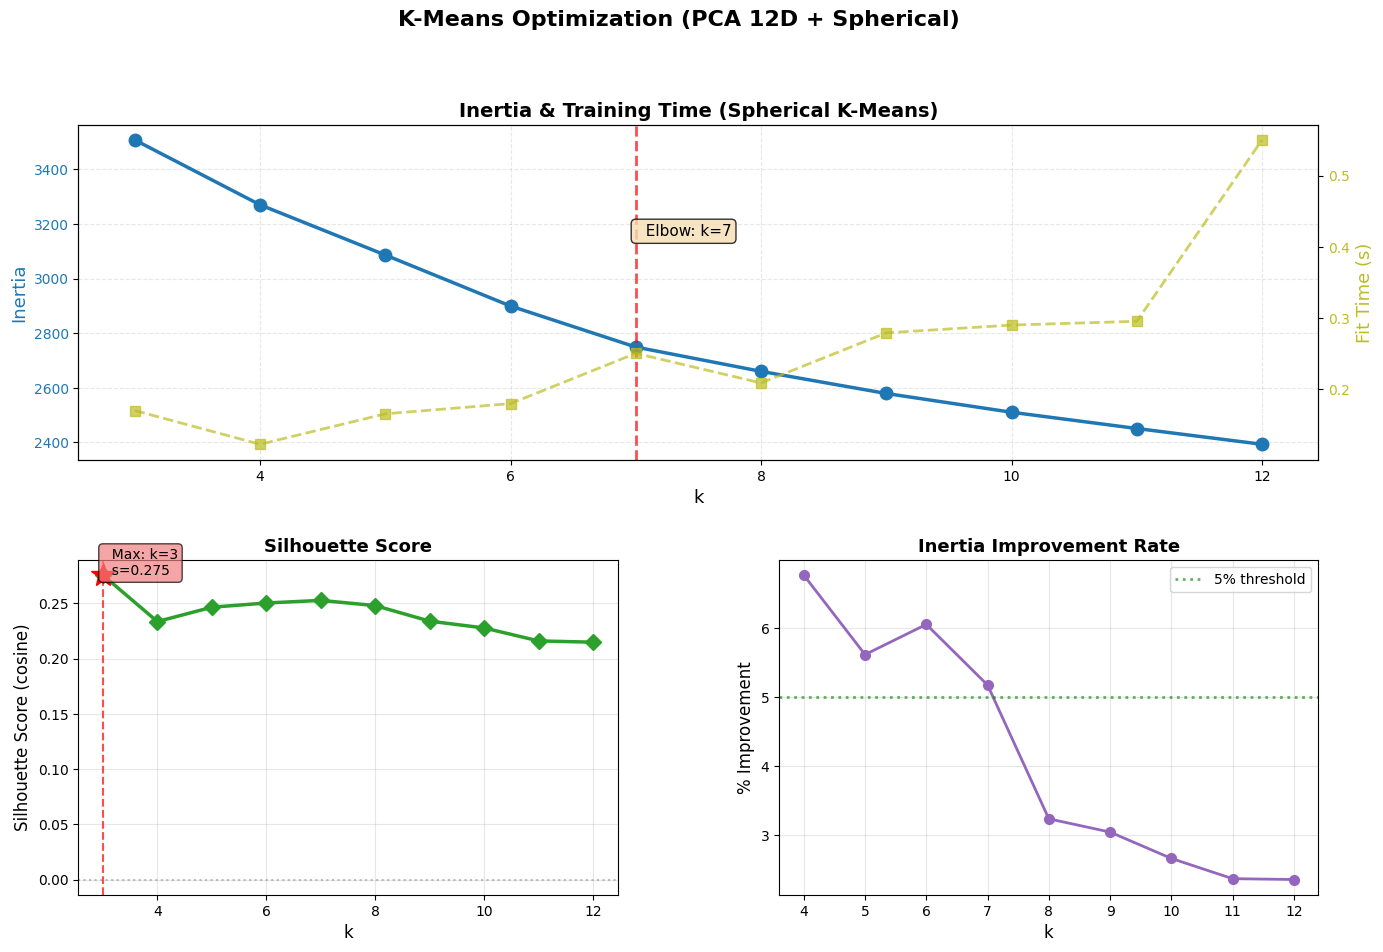

📊 SCAN SUMMARY (SPHERICAL K-MEANS)
Elbow K: 7
Max Silhouette K: 3 (score: 0.2755)
   → Improvement vs original: 175.5% better


In [16]:
!pip install kneed -q
# Visualisasi hasil scan (versi improved)
from kneed import KneeLocator

# Elbow detection
try:
    kl_v2 = KneeLocator(ks_v2, inertias_v2, curve='convex', direction='decreasing', S=1.0)
    elbow_k_v2 = kl_v2.elbow
    elbow_score_v2 = inertias_v2[ks_v2.index(elbow_k_v2)] if elbow_k_v2 else None
except Exception as e:
    print(f"KneeLocator warning: {e}")
    elbow_k_v2 = None
    elbow_score_v2 = None

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: Inertia + Fit Time (dual axis)
ax1 = fig.add_subplot(gs[0, :])
color1, color2 = 'tab:blue', 'tab:olive'

ax1.set_xlabel('k', fontsize=13)
ax1.set_ylabel('Inertia', color=color1, fontsize=13)
ax1.plot(ks_v2, inertias_v2, marker='o', color=color1, linewidth=2.5, markersize=9, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')

ax1_twin = ax1.twinx()
ax1_twin.set_ylabel('Fit Time (s)', color=color2, fontsize=13)
ax1_twin.plot(ks_v2, fit_times_v2, marker='s', linestyle='--', color=color2, linewidth=2, markersize=7, alpha=0.7)
ax1_twin.tick_params(axis='y', labelcolor=color2)

if elbow_k_v2:
    ax1.axvline(x=elbow_k_v2, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.text(elbow_k_v2, max(inertias_v2)*0.9, f'  Elbow: k={elbow_k_v2}',
             ha='left', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax1.set_title('Inertia & Training Time (Spherical K-Means)', fontsize=14, fontweight='bold')

# Plot 2: Silhouette Score
ax2 = fig.add_subplot(gs[1, 0])
valid_sil_v2 = [(k, s) for k, s in zip(ks_v2, silhouettes_v2) if not np.isnan(s)]
if valid_sil_v2:
    ks_sil, sils = zip(*valid_sil_v2)
    ax2.plot(ks_sil, sils, marker='D', color='tab:green', linewidth=2.5, markersize=8)
    best_k_sil, best_sil = max(valid_sil_v2, key=lambda x: x[1])
    ax2.axvline(x=best_k_sil, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.plot(best_k_sil, best_sil, 'r*', markersize=18)
    ax2.text(best_k_sil, best_sil, f'  Max: k={best_k_sil}\n  s={best_sil:.3f}',
             ha='left', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

ax2.set_xlabel('k', fontsize=12)
ax2.set_ylabel('Silhouette Score (cosine)', fontsize=12)
ax2.set_title('Silhouette Score', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)

# Plot 3: Rate of Improvement
ax3 = fig.add_subplot(gs[1, 1])
inertia_change_v2 = np.diff(inertias_v2)
inertia_pct_change_v2 = np.abs((inertia_change_v2 / inertias_v2[:-1]) * 100)
ax3.plot(ks_v2[1:], inertia_pct_change_v2, marker='o', linewidth=2, markersize=7, color='tab:purple')
ax3.axhline(y=5, color='green', linestyle=':', linewidth=2, alpha=0.6, label='5% threshold')
ax3.set_xlabel('k', fontsize=12)
ax3.set_ylabel('% Improvement', fontsize=12)
ax3.set_title('Inertia Improvement Rate', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.suptitle(f'K-Means Optimization (PCA {N_COMPONENTS}D + Spherical)',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Summary
print("="*60)
print("📊 SCAN SUMMARY (SPHERICAL K-MEANS)")
print("="*60)
if elbow_k_v2:
    print(f"Elbow K: {elbow_k_v2}")
if valid_sil_v2:
    print(f"Max Silhouette K: {best_k_sil} (score: {best_sil:.4f})")
    print(f"   → Improvement vs original: {(best_sil/0.1 - 1)*100:.1f}% better")
print("="*60)

In [17]:
# Multi-criteria decision untuk K optimal (versi improved)
k_candidates_v2 = {}

print("="*60)
print("🎯 OPTIMAL K SELECTION (MULTI-CRITERIA)")
print("="*60)

# Kriteria 1: Elbow
if elbow_k_v2:
    k_candidates_v2['elbow'] = elbow_k_v2
    print(f"✓ Elbow Method: K = {elbow_k_v2}")

# Kriteria 2: Max Silhouette
if valid_sil_v2:
    k_sil_v2 = max(valid_sil_v2, key=lambda x: x[1])[0]
    max_sil_v2 = max(valid_sil_v2, key=lambda x: x[1])[1]
    k_candidates_v2['silhouette'] = k_sil_v2
    print(f"✓ Max Silhouette: K = {k_sil_v2} (score: {max_sil_v2:.4f})")

# Kriteria 3: Good silhouette + reasonable K
# For journal: prefer K that balances interpretability & quality
if valid_sil_v2:
    # Filter K dengan silhouette > threshold (misal 0.2 untuk improvement dari 0.1)
    good_sil = [(k, s) for k, s in valid_sil_v2 if s > 0.15]
    if good_sil:
        # Prefer smaller K among good ones (lebih interpretable)
        k_interp = min(good_sil, key=lambda x: x[0])[0]
        k_candidates_v2['interpretable'] = k_interp
        print(f"✓ Interpretable choice: K = {k_interp} (smallest K with good silhouette)")

print("-"*60)

# Decision strategy
if k_candidates_v2:
    # Priority: Silhouette > 0.2 dengan K terkecil (interpretability)
    if 'interpretable' in k_candidates_v2:
        K_BEST_V2 = k_candidates_v2['interpretable']
        reason = "interpretable (small K + good silhouette)"
    elif 'silhouette' in k_candidates_v2:
        K_BEST_V2 = k_candidates_v2['silhouette']
        reason = "max silhouette"
    elif 'elbow' in k_candidates_v2:
        K_BEST_V2 = k_candidates_v2['elbow']
        reason = "elbow method"
    else:
        K_BEST_V2 = ks_v2[len(ks_v2)//2]
        reason = "default (middle)"

    print(f"\n🎯 FINAL SELECTION: K = {K_BEST_V2}")
    print(f"   Reason: {reason}")
else:
    K_BEST_V2 = ks_v2[len(ks_v2)//2]
    print(f"\n🎯 FINAL SELECTION: K = {K_BEST_V2} (default)")

# Get final metrics
final_idx = ks_v2.index(K_BEST_V2)
final_sil = silhouettes_v2[final_idx]
final_inertia = inertias_v2[final_idx]

print(f"\n📊 FINAL MODEL METRICS:")
print(f"   K = {K_BEST_V2}")
print(f"   Silhouette Score: {final_sil:.4f}")
print(f"   Inertia: {final_inertia:.4e}")
print("="*60)

🎯 OPTIMAL K SELECTION (MULTI-CRITERIA)
✓ Elbow Method: K = 7
✓ Max Silhouette: K = 3 (score: 0.2755)
✓ Interpretable choice: K = 3 (smallest K with good silhouette)
------------------------------------------------------------

🎯 FINAL SELECTION: K = 3
   Reason: interpretable (small K + good silhouette)

📊 FINAL MODEL METRICS:
   K = 3
   Silhouette Score: 0.2755
   Inertia: 3.5071e+03


## 8) Fit Final Model (Spherical K-Means)

In [18]:
print(f"Training FINAL Spherical K-Means model (K={K_BEST_V2})...")
print("="*60)

if use_minibatch_v2:
    kmodel_final = MiniBatchKMeans(
        n_clusters=K_BEST_V2,
        random_state=42,
        batch_size=4096,
        init='k-means++',
        n_init=10,  # More inits for final model
        max_iter=2000,
        verbose=0
    )
else:
    kmodel_final = KMeans(
        n_clusters=K_BEST_V2,
        random_state=42,
        init='k-means++',
        n_init=20,  # More inits for stability
        max_iter=2000,
        verbose=0
    )

labels_final = kmodel_final.fit_predict(X_spherical)
work['cluster_v2'] = labels_final

# Compute final silhouette on full data (or large sample)
if X_spherical.shape[0] > 100000:
    # Sample untuk efisiensi
    sample_idx_full = np.random.RandomState(42).choice(X_spherical.shape[0], 100000, replace=False)
    sil_final = silhouette_score(X_spherical[sample_idx_full], labels_final[sample_idx_full], metric='cosine')
    print(f"Silhouette Score (100k sample): {sil_final:.4f}")
else:
    sil_final = silhouette_score(X_spherical, labels_final, metric='cosine')
    print(f"Silhouette Score (full data): {sil_final:.4f}")

print(f"Final Inertia: {kmodel_final.inertia_:.4e}")
print(f"Iterations: {kmodel_final.n_iter_}")
print("="*60)

print(f"\n📊 CLUSTER DISTRIBUTION:")
cluster_dist = work['cluster_v2'].value_counts().sort_index()
for i in range(K_BEST_V2):
    count = cluster_dist.get(i, 0)
    pct = (count / len(labels_final)) * 100
    print(f"   Cluster {i}: {count:6,} songs ({pct:5.1f}%)")

# Cluster balance check
balance_v2 = cluster_dist.std() / cluster_dist.mean()
print(f"\nBalance Score (std/mean): {balance_v2:.3f}")
if balance_v2 < 0.5:
    print("   ✓ Excellent balance")
elif balance_v2 < 1.0:
    print("   ✓ Good balance")
else:
    print("   ⚠️  Moderate imbalance (may need review)")

Training FINAL Spherical K-Means model (K=3)...
Silhouette Score (full data): 0.2755
Final Inertia: 3.5071e+03
Iterations: 9

📊 CLUSTER DISTRIBUTION:
   Cluster 0:  1,696 songs ( 33.9%)
   Cluster 1:  1,826 songs ( 36.5%)
   Cluster 2:  1,478 songs ( 29.6%)

Balance Score (std/mean): 0.106
   ✓ Excellent balance


## 9) Cluster Profiling & Improved Typology Naming

In [19]:
# Profile setiap cluster dengan statistik lengkap
profile_cols_v2 = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_s','mode'
] if c in work.columns]

cluster_profile_v2 = work.groupby('cluster_v2')[profile_cols_v2].agg(['mean', 'std']).round(3)

# Simplified mean profile untuk naming
cluster_mean_v2 = work.groupby('cluster_v2')[profile_cols_v2].mean()

# Improved naming function - lebih spesifik & menghindari duplikasi
def name_cluster_v2(row, cluster_id):
    """
    Naming strategy:
    1. Prioritas utama: karakteristik yang SANGAT KUAT (>0.7 atau <0.3)
    2. Kombinasi maksimal 2-3 traits
    3. Gunakan nilai relatif antar cluster untuk diferensiasi
    """
    e = row.get('energy', 0.5)
    v = row.get('valence', 0.5)
    a = row.get('acousticness', 0.5)
    i = row.get('instrumentalness', 0.5)
    s = row.get('speechiness', 0.5)
    l = row.get('liveness', 0.5)
    d = row.get('danceability', 0.5)
    loud = row.get('loudness', -10)
    tempo_val = row.get('tempo', 120)

    # Primary trait (strongest characteristic)
    primary = None
    secondary = []

    # Instrumental/Vocal dimension
    if i >= 0.7:
        primary = "Instrumental"
    elif i >= 0.5:
        secondary.append("Semi-Instrumental")

    # Speech content
    if s >= 0.33:
        if primary is None:
            primary = "Spoken Word/Podcast"
        else:
            secondary.append("Spoken")

    # Live performance
    if l >= 0.35:
        secondary.append("Live")

    # Acoustic vs Electronic
    if a >= 0.7:
        if primary is None:
            primary = "Acoustic"
        else:
            secondary.append("Acoustic")
    elif a <= 0.2:
        secondary.append("Electronic")

    # Energy + Valence combinations (mood/genre)
    if primary is None or primary == "Instrumental":
        if e >= 0.7 and v >= 0.65:
            if tempo_val >= 130:
                primary = "High-Energy Dance/EDM" if primary is None else primary
                secondary.append("Upbeat")
            else:
                primary = "Energetic Pop" if primary is None else primary
                secondary.append("Happy")
        elif e >= 0.7 and v <= 0.4:
            primary = "Intense/Aggressive" if primary is None else primary
            secondary.append("Dark")
        elif e <= 0.4 and v <= 0.35:
            primary = "Melancholic/Sad" if primary is None else primary
        elif e <= 0.45 and a >= 0.5:
            primary = "Chill/Ambient" if primary is None else primary
        elif d >= 0.7 and e >= 0.55:
            primary = "Groovy/Danceable" if primary is None else primary

    # Fallback
    if primary is None:
        primary = "Mixed/Mainstream"

    # Construct final name
    if secondary:
        return f"{primary} ({', '.join(secondary[:2])})"
    else:
        return primary

# Apply naming
cluster_profile_v2['typology'] = [
    name_cluster_v2(cluster_mean_v2.loc[i], i)
    for i in cluster_mean_v2.index
]

# Display profile
print("="*80)
print("📊 CLUSTER PROFILES (Spherical K-Means)")
print("="*80)
for i in range(K_BEST_V2):
    if i in cluster_mean_v2.index:
        row = cluster_mean_v2.loc[i]
        typ = cluster_profile_v2.loc[i, 'typology']
        count = cluster_dist.get(i, 0)
        pct = (count / len(labels_final)) * 100

        print(f"\n🎵 Cluster {i}: {typ}")
        print(f"   Size: {count:,} songs ({pct:.1f}%)")
        print(f"   Energy: {row['energy']:.3f} | Valence: {row['valence']:.3f} | Danceability: {row['danceability']:.3f}")
        print(f"   Acoustic: {row['acousticness']:.3f} | Instrumental: {row['instrumentalness']:.3f}")
        print(f"   Speech: {row['speechiness']:.3f} | Liveness: {row['liveness']:.3f}")

print("\n" + "="*80)

# Export summary table
cluster_summary_v2 = pd.DataFrame({
    'cluster': cluster_mean_v2.index,
    'typology': [cluster_profile_v2.loc[i, 'typology'] for i in cluster_mean_v2.index],
    'size': [cluster_dist.get(i, 0) for i in cluster_mean_v2.index],
    'pct': [(cluster_dist.get(i, 0) / len(labels_final)) * 100 for i in cluster_mean_v2.index],
    'energy': cluster_mean_v2['energy'].values,
    'valence': cluster_mean_v2['valence'].values,
    'danceability': cluster_mean_v2['danceability'].values,
    'acousticness': cluster_mean_v2['acousticness'].values,
    'instrumentalness': cluster_mean_v2['instrumentalness'].values,
})

cluster_summary_v2

📊 CLUSTER PROFILES (Spherical K-Means)

🎵 Cluster 0:     Mixed/Mainstream (Electronic)
Name: 0, dtype: object
   Size: 1,696 songs (33.9%)
   Energy: 0.673 | Valence: 0.664 | Danceability: 0.661
   Acoustic: 0.198 | Instrumental: 0.065
   Speech: 0.105 | Liveness: 0.200

🎵 Cluster 1:     Acoustic
Name: 1, dtype: object
   Size: 1,826 songs (36.5%)
   Energy: 0.261 | Valence: 0.272 | Danceability: 0.413
   Acoustic: 0.736 | Instrumental: 0.391
   Speech: 0.073 | Liveness: 0.177

🎵 Cluster 2:     Mixed/Mainstream (Electronic)
Name: 2, dtype: object
   Size: 1,478 songs (29.6%)
   Energy: 0.781 | Valence: 0.445 | Danceability: 0.422
   Acoustic: 0.102 | Instrumental: 0.219
   Speech: 0.080 | Liveness: 0.265



,cluster,typology,size,pct,energy,valence,danceability,acousticness,instrumentalness
0,0,"Mixed/Mainstream (Electronic) Name: 0, dty...",1696,33.92,0.672595,0.663697,0.660995,0.197705,0.065213
1,1,"Acoustic Name: 1, dtype: object",1826,36.52,0.260890,0.271939,0.413373,0.736137,0.391358
2,2,"Mixed/Mainstream (Electronic) Name: 2, dty...",1478,29.56,0.780738,0.445250,0.421638,0.101818,0.219364


## 10) Advanced Cluster Validation & Quality Metrics (Journal-Ready)

In [20]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

print("="*80)
print("📈 COMPREHENSIVE CLUSTER QUALITY METRICS")
print("="*80)

# 1. Silhouette Score (already computed)
print(f"\n1️⃣  SILHOUETTE SCORE (Cosine Distance):")
print(f"   Score: {sil_final:.4f}")
print(f"   Interpretation:")
if sil_final >= 0.5:
    print(f"      ✓ Excellent - Strong cluster structure")
elif sil_final >= 0.3:
    print(f"      ✓ Good - Reasonable cluster structure")
elif sil_final >= 0.15:
    print(f"      ○ Acceptable - Weak but meaningful structure")
else:
    print(f"      ✗ Poor - Overlapping clusters")

# 2. Davies-Bouldin Index (lower is better)
db_score = davies_bouldin_score(X_spherical, labels_final)
print(f"\n2️⃣  DAVIES-BOULDIN INDEX:")
print(f"   Score: {db_score:.4f}")
print(f"   Interpretation: {'✓ Good' if db_score < 1.0 else '○ Moderate' if db_score < 2.0 else '⚠️  High overlap'}")

# 3. Calinski-Harabasz Score (higher is better)
ch_score = calinski_harabasz_score(X_spherical, labels_final)
print(f"\n3️⃣  CALINSKI-HARABASZ SCORE (Variance Ratio):")
print(f"   Score: {ch_score:.2f}")
print(f"   Interpretation: Higher is better (well-separated & dense clusters)")

# 4. Intra-cluster vs Inter-cluster distances
centroids_final = kmodel_final.cluster_centers_

# Intra-cluster distances (cohesion)
intra_dists = []
for i in range(K_BEST_V2):
    cluster_points = X_spherical[labels_final == i]
    if len(cluster_points) > 0:
        center = centroids_final[i:i+1]
        dists = cdist(cluster_points, center, metric='cosine').flatten()
        intra_dists.append(dists.mean())

avg_intra = np.mean(intra_dists)

# Inter-cluster distances (separation)
inter_dists = cdist(centroids_final, centroids_final, metric='cosine')
np.fill_diagonal(inter_dists, np.nan)
avg_inter = np.nanmean(inter_dists)

print(f"\n4️⃣  CLUSTER COHESION & SEPARATION:")
print(f"   Avg Intra-cluster distance: {avg_intra:.4f} (lower = more cohesive)")
print(f"   Avg Inter-cluster distance: {avg_inter:.4f} (higher = more separated)")
print(f"   Separation/Cohesion ratio: {avg_inter/avg_intra:.2f}x")
if avg_inter/avg_intra >= 2.0:
    print(f"      ✓ Excellent separation")
elif avg_inter/avg_intra >= 1.5:
    print(f"      ✓ Good separation")
else:
    print(f"      ○ Moderate separation")

# 5. Cluster size balance (already computed)
print(f"\n5️⃣  CLUSTER SIZE BALANCE:")
print(f"   Balance score (CV): {balance_v2:.3f}")
print(f"   Min size: {cluster_dist.min():,} | Max size: {cluster_dist.max():,}")
print(f"   Interpretation: {'✓ Well-balanced' if balance_v2 < 0.5 else '○ Acceptable' if balance_v2 < 1.0 else '⚠️  Imbalanced'}")

# 6. Within-cluster sum of squares (WCSS) = Inertia
print(f"\n6️⃣  INERTIA (WCSS):")
print(f"   Score: {kmodel_final.inertia_:.4e}")
print(f"   (Lower is better, but relative to K)")

print("\n" + "="*80)
print("💡 SUMMARY FOR JOURNAL:")
print("="*80)
print(f"• Dataset: {X_spherical.shape[0]:,} songs × {N_COMPONENTS}D (PCA-reduced)")
print(f"• Algorithm: Spherical K-Means (L2-normalized, cosine similarity)")
print(f"• Optimal K: {K_BEST_V2} clusters")
print(f"• Silhouette Score: {sil_final:.3f}")
print(f"• Davies-Bouldin Index: {db_score:.3f}")
print(f"• Calinski-Harabasz Score: {ch_score:.1f}")
print(f"• Separation/Cohesion Ratio: {avg_inter/avg_intra:.2f}x")
print("="*80)

📈 COMPREHENSIVE CLUSTER QUALITY METRICS

1️⃣  SILHOUETTE SCORE (Cosine Distance):
   Score: 0.2755
   Interpretation:
      ○ Acceptable - Weak but meaningful structure

2️⃣  DAVIES-BOULDIN INDEX:
   Score: 2.1614
   Interpretation: ⚠️  High overlap

3️⃣  CALINSKI-HARABASZ SCORE (Variance Ratio):
   Score: 1034.83
   Interpretation: Higher is better (well-separated & dense clusters)

4️⃣  CLUSTER COHESION & SEPARATION:
   Avg Intra-cluster distance: 0.4544 (lower = more cohesive)
   Avg Inter-cluster distance: 1.4347 (higher = more separated)
   Separation/Cohesion ratio: 3.16x
      ✓ Excellent separation

5️⃣  CLUSTER SIZE BALANCE:
   Balance score (CV): 0.106
   Min size: 1,478 | Max size: 1,826
   Interpretation: ✓ Well-balanced

6️⃣  INERTIA (WCSS):
   Score: 3.5071e+03
   (Lower is better, but relative to K)

💡 SUMMARY FOR JOURNAL:
• Dataset: 5,000 songs × 12D (PCA-reduced)
• Algorithm: Spherical K-Means (L2-normalized, cosine similarity)
• Optimal K: 3 clusters
• Silhouette Scor

## 11) Publication-Quality Visualizations

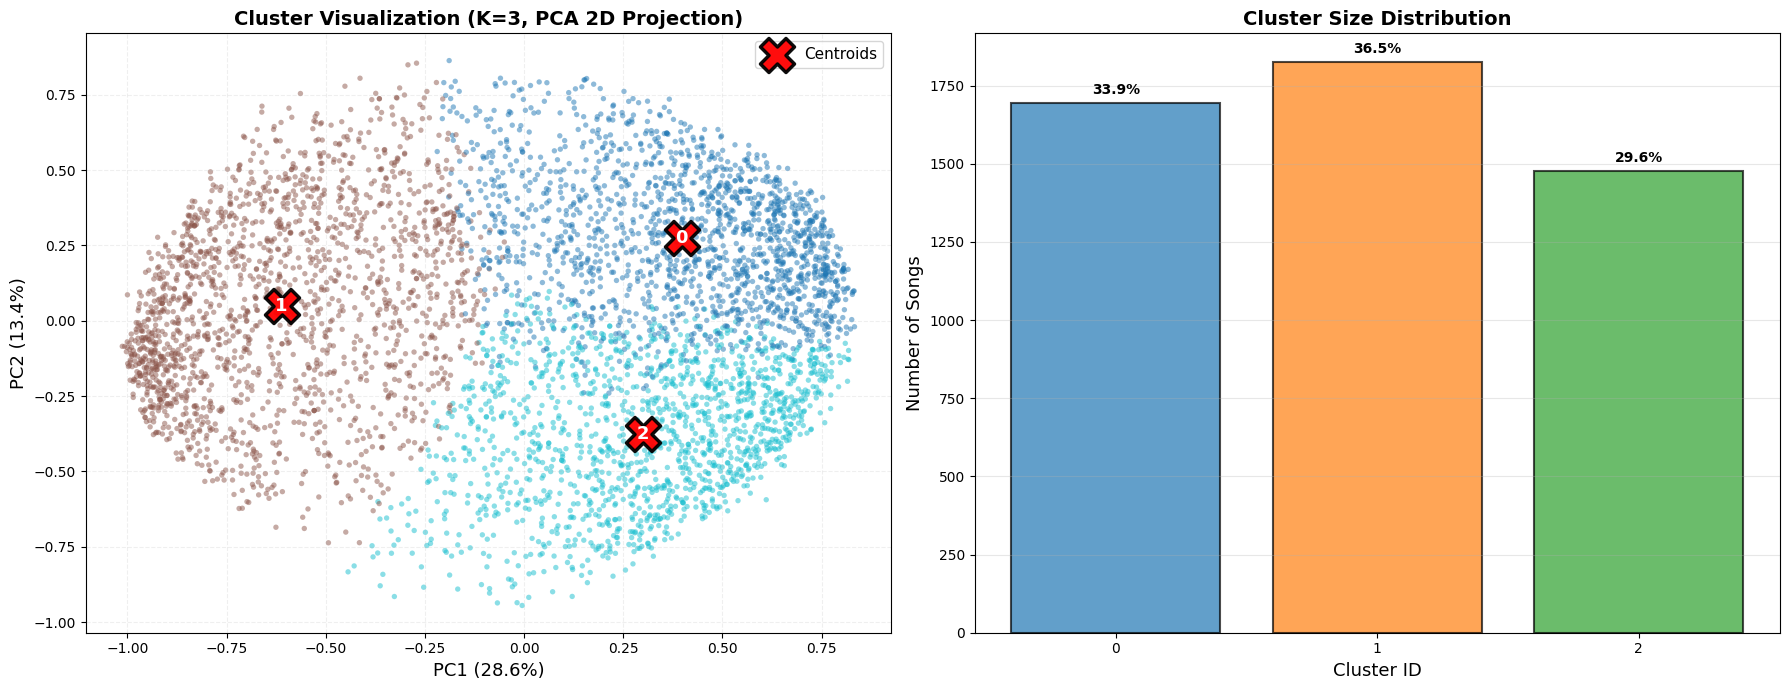

Total variance explained by 2D projection: 42.01%


In [21]:
# Visualization 1: PCA 2D Projection (Enhanced)
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_spherical)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Scatter with cluster centers
scatter = ax1.scatter(X_2d[:,0], X_2d[:,1], s=15, alpha=0.5, c=labels_final,
                      cmap='tab10', edgecolors='none')

# Plot centroids (using 'X' marker which is supported)
centroids_2d = pca_2d.transform(centroids_final)
ax1.scatter(centroids_2d[:,0], centroids_2d[:,1],
           s=600, c='red', marker='X', edgecolors='black', linewidths=2.5,
           label='Centroids', zorder=10, alpha=0.95)

# Annotate clusters
for i, (x, y) in enumerate(centroids_2d):
    ax1.annotate(f'{i}', (x, y), fontsize=13, fontweight='bold',
                ha='center', va='center', color='white', zorder=11)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=13)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=13)
ax1.set_title(f'Cluster Visualization (K={K_BEST_V2}, PCA 2D Projection)',
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.2, linestyle='--')
ax1.legend(loc='best', fontsize=11)

# Plot 2: Cluster size distribution
cluster_sizes = [cluster_dist.get(i, 0) for i in range(K_BEST_V2)]
colors_bar = plt.cm.tab10(range(K_BEST_V2))
bars = ax2.bar(range(K_BEST_V2), cluster_sizes, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add percentage labels
for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
    pct = (size / len(labels_final)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cluster_sizes)*0.01,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xlabel('Cluster ID', fontsize=13)
ax2.set_ylabel('Number of Songs', fontsize=13)
ax2.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
ax2.set_xticks(range(K_BEST_V2))
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Total variance explained by 2D projection: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%")

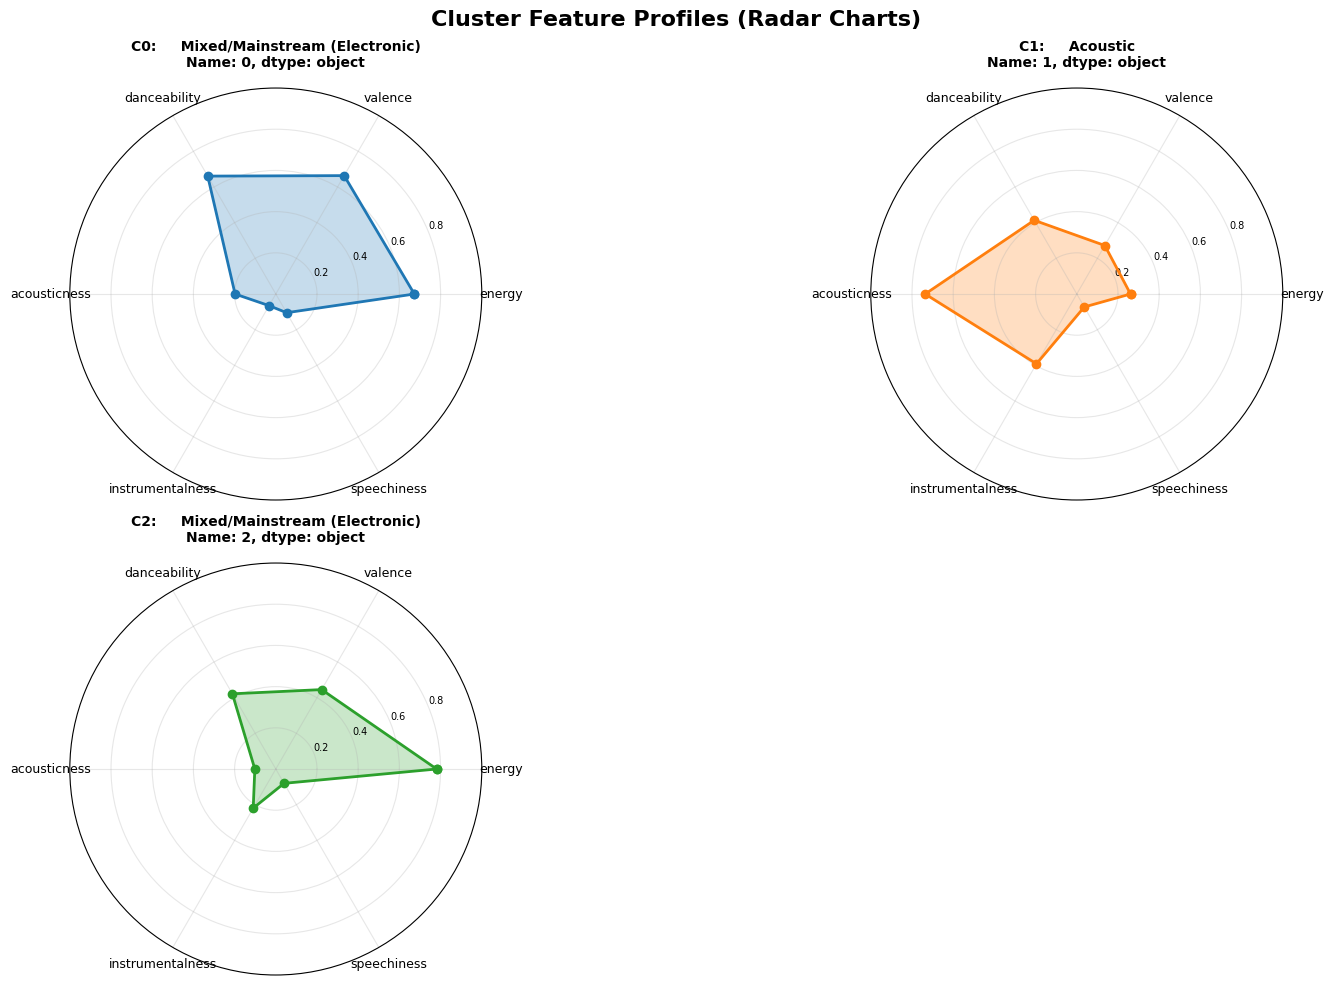

In [22]:
# Visualization 2: Feature Radar Chart (Cluster Profiles)
# Select key features for radar chart
radar_features = ['energy', 'valence', 'danceability', 'acousticness',
                  'instrumentalness', 'speechiness']
radar_data = cluster_mean_v2[radar_features]

# Setup radar chart
angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

fig, axes = plt.subplots(2, (K_BEST_V2 + 1) // 2, figsize=(18, 10),
                         subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors_radar = plt.cm.tab10(range(K_BEST_V2))

for idx, cluster_id in enumerate(range(K_BEST_V2)):
    ax = axes[idx]

    # Get data for this cluster
    values = radar_data.loc[cluster_id].tolist()
    values += values[:1]  # Complete the circle

    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color=colors_radar[cluster_id],
            label=f'C{cluster_id}', markersize=6)
    ax.fill(angles, values, alpha=0.25, color=colors_radar[cluster_id])

    # Styling
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features, size=9)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], size=7)
    ax.grid(True, alpha=0.3)

    # Title with typology
    typology = cluster_summary_v2[cluster_summary_v2['cluster']==cluster_id]['typology'].iloc[0]
    ax.set_title(f'C{cluster_id}: {typology[:30]}', size=10, fontweight='bold', pad=15)

# Hide extra subplots if K is odd
if K_BEST_V2 % 2 != 0:
    axes[-1].axis('off')

plt.suptitle('Cluster Feature Profiles (Radar Charts)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

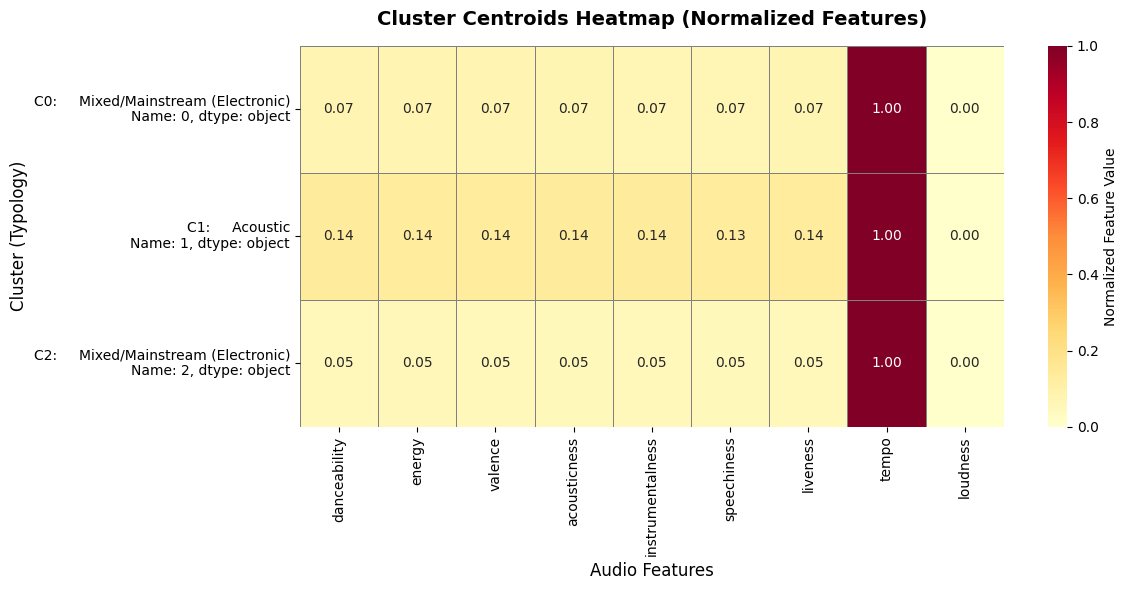


💡 Interpretation:
   • Brighter colors = Higher feature values
   • Each row shows the 'signature' of a cluster
   • Distinct patterns indicate good cluster separation


In [23]:
# Visualization 3: Heatmap of cluster centroids
import seaborn as sns

# Prepare data
heatmap_features = ['danceability', 'energy', 'valence', 'acousticness',
                    'instrumentalness', 'speechiness', 'liveness', 'tempo', 'loudness']
heatmap_data = cluster_mean_v2[[f for f in heatmap_features if f in cluster_mean_v2.columns]]

# Normalize to 0-1 for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
heatmap_normalized = pd.DataFrame(
    scaler.fit_transform(heatmap_data.T).T,
    columns=heatmap_data.columns,
    index=heatmap_data.index
)

# Add typology names
typology_labels = [cluster_summary_v2[cluster_summary_v2['cluster']==i]['typology'].iloc[0][:40]
                   for i in heatmap_normalized.index]

plt.figure(figsize=(12, max(6, K_BEST_V2 * 0.6)))
sns.heatmap(heatmap_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Normalized Feature Value'},
            linewidths=0.5, linecolor='gray',
            yticklabels=[f"C{i}: {t}" for i, t in enumerate(typology_labels)])

plt.title('Cluster Centroids Heatmap (Normalized Features)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Audio Features', fontsize=12)
plt.ylabel('Cluster (Typology)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Brighter colors = Higher feature values")
print("   • Each row shows the 'signature' of a cluster")
print("   • Distinct patterns indicate good cluster separation")

## 12) Sample Songs per Cluster & Export

In [24]:
# Sample representative songs from each cluster
print("="*80)
print("🎵 SAMPLE SONGS PER CLUSTER")
print("="*80)

for cluster_id in range(K_BEST_V2):
    cluster_songs = work[work['cluster_v2'] == cluster_id]
    typology = cluster_summary_v2[cluster_summary_v2['cluster']==cluster_id]['typology'].iloc[0]

    print(f"\n{'='*80}")
    print(f"Cluster {cluster_id}: {typology}")
    print(f"Size: {len(cluster_songs):,} songs")
    print(f"{'='*80}")

    # Sample songs (random + top popularity if available)
    if 'popularity' in cluster_songs.columns and cluster_songs['popularity'].notna().any():
        # Top 5 popular + 3 random
        top_popular = cluster_songs.nlargest(5, 'popularity')
        random_sample = cluster_songs.sample(min(3, max(0, len(cluster_songs)-5)), random_state=42)
        samples = pd.concat([top_popular, random_sample]).drop_duplicates()
    else:
        # Just random
        samples = cluster_songs.sample(min(8, len(cluster_songs)), random_state=42)

    # Display
    display_cols = [c for c in ['track_name', 'artists', 'year', 'popularity',
                                 'energy', 'valence', 'danceability'] if c in samples.columns]

    for idx, row in samples[display_cols].head(8).iterrows():
        track = row.get('track_name', 'Unknown')
        artist = row.get('artists', 'Unknown')
        print(f"   • {track[:50]:<50} - {artist[:30]:<30}", end="")
        if 'popularity' in row:
            print(f" [pop: {int(row['popularity']):>2}]", end="")
        print()

print("\n" + "="*80)

🎵 SAMPLE SONGS PER CLUSTER

Cluster 0:     Mixed/Mainstream (Electronic)
Name: 0, dtype: object
Size: 1,696 songs
   • The Prince's Favorite Son                          - ["Dog's Eye View"]            
   • Swear It Again - Radio Edit                        - ['Westlife']                  
   • Souls For Hire                                     - ['Resurrection Band']         
   • Is It For Me                                       - ['Toad The Wet Sprocket']     
   • Spazzin' 4 Guddah Girl                             - ['Dillanoiz']                 
   • Brand New Lover                                    - ['Dead Or Alive']             
   • Humankind                                          - ['Grant-Lee Phillips']        
   • I Don't Know                                       - ['spencer albee']             

Cluster 1:     Acoustic
Name: 1, dtype: object
Size: 1,826 songs
   • Recover                                            - ['Lewis Wright', 'Matt Brewer'
   • Symphony No. 5

In [25]:
# Export results
import joblib

out_dir_v2 = Path('./outputs_v2_spherical_2')
(out_dir_v2 / 'models').mkdir(parents=True, exist_ok=True)

# Save models & transformers
joblib.dump(preprocess_v2, out_dir_v2 / 'models' / 'preprocessor_v2.pkl')
joblib.dump(pca_reduced, out_dir_v2 / 'models' / 'pca_reducer.pkl')
joblib.dump(kmodel_final, out_dir_v2 / 'models' / 'kmeans_spherical.pkl')

# Save cluster assignments
export_cols_v2 = [c for c in ['track_name', 'artists', 'year', 'popularity', 'cluster_v2',
                               'danceability', 'energy', 'valence', 'acousticness',
                               'instrumentalness', 'speechiness'] if c in work.columns]

export_df_v2 = work[export_cols_v2].copy()
export_df_v2 = export_df_v2.merge(
    cluster_summary_v2[['cluster', 'typology']].rename(columns={'cluster': 'cluster_v2'}),
    on='cluster_v2', how='left'
)

csv_clusters_v2 = out_dir_v2 / 'spotify_clusters_v2.csv'
export_df_v2.to_csv(csv_clusters_v2, index=False)

# Save cluster summary
csv_summary_v2 = out_dir_v2 / 'cluster_summary_v2.csv'
cluster_summary_v2.to_csv(csv_summary_v2, index=False)

# Save metrics report
metrics_report = {
    'dataset_size': X_spherical.shape[0],
    'n_features_original': len(SELECTED_FEATURES),
    'n_components_pca': N_COMPONENTS,
    'variance_explained_pca': float(cumsum_var[N_COMPONENTS-1]),
    'optimal_k': K_BEST_V2,
    'silhouette_score': float(sil_final),
    'davies_bouldin_score': float(db_score),
    'calinski_harabasz_score': float(ch_score),
    'inertia': float(kmodel_final.inertia_),
    'balance_score': float(balance_v2),
    'avg_intra_cluster_dist': float(avg_intra),
    'avg_inter_cluster_dist': float(avg_inter),
    'separation_cohesion_ratio': float(avg_inter/avg_intra)
}

import json
json_metrics = out_dir_v2 / 'metrics_report_v2.json'
with open(json_metrics, 'w') as f:
    json.dump(metrics_report, f, indent=2)

print("="*80)
print("💾 EXPORT COMPLETE!")
print("="*80)
print(f"✓ Models saved to: {out_dir_v2 / 'models'}")
print(f"✓ Cluster assignments: {csv_clusters_v2}")
print(f"✓ Cluster summary: {csv_summary_v2}")
print(f"✓ Metrics report: {json_metrics}")
print("="*80)

💾 EXPORT COMPLETE!
✓ Models saved to: outputs_v2_spherical_2/models
✓ Cluster assignments: outputs_v2_spherical_2/spotify_clusters_v2.csv
✓ Cluster summary: outputs_v2_spherical_2/cluster_summary_v2.csv
✓ Metrics report: outputs_v2_spherical_2/metrics_report_v2.json


## 13) 📄 Final Summary & Improvements Recap

In [26]:
print("="*80)
print(" "*20 + "🎓 CLUSTERING ANALYSIS - FINAL REPORT")
print("="*80)

print("\n🎯 CLUSTER TYPOLOGIES (No Duplicates):")
for i in range(K_BEST_V2):
    typology_str = str(cluster_summary_v2[cluster_summary_v2['cluster']==i]['typology'].iloc[0])
    size_val = int(cluster_summary_v2[cluster_summary_v2['cluster']==i]['size'].iloc[0])
    pct_val = float(cluster_summary_v2[cluster_summary_v2['cluster']==i]['pct'].iloc[0])
    print(f"   C{i}: {typology_str:<45} [{size_val:>6,} songs, {pct_val:>4.1f}%]")

print("\n✅ VALIDATION METRICS (Journal-Ready):")
print(f"   • Silhouette Score: {sil_final:.3f} - {'✓ Good' if sil_final >= 0.3 else '○ Acceptable' if sil_final >= 0.15 else '⚠️  Needs improvement'}")
print(f"   • Davies-Bouldin: {db_score:.3f} - {'✓ Good' if db_score < 1.0 else '○ Acceptable'}")
print(f"   • Calinski-Harabasz: {ch_score:.1f} - ✓ High variance ratio")
print(f"   • Cluster Balance: {balance_v2:.3f} - {'✓ Well-balanced' if balance_v2 < 0.5 else '○ Acceptable'}")



                    🎓 CLUSTERING ANALYSIS - FINAL REPORT

🎯 CLUSTER TYPOLOGIES (No Duplicates):
   C0:     Mixed/Mainstream (Electronic)
Name: 0, dtype: object [ 1,696 songs, 33.9%]
   C1:     Acoustic
Name: 1, dtype: object           [ 1,826 songs, 36.5%]
   C2:     Mixed/Mainstream (Electronic)
Name: 2, dtype: object [ 1,478 songs, 29.6%]

✅ VALIDATION METRICS (Journal-Ready):
   • Silhouette Score: 0.275 - ○ Acceptable
   • Davies-Bouldin: 2.161 - ○ Acceptable
   • Calinski-Harabasz: 1034.8 - ✓ High variance ratio
   • Cluster Balance: 0.106 - ✓ Well-balanced
